<a href="https://colab.research.google.com/github/HenryLau08/adsai-mlops-2025/blob/main/MLOPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install kaggle

In [ ]:
%pip install ultralytics

In [ ]:
%pip install mlflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imports
import os
from pathlib import Path
import cv2
import shutil
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split
import yaml
from ultralytics import YOLO
import mlflow

base_dir = Path("/content/drive/MyDrive/Colab Notebooks/data")
base_dir.mkdir(parents=True, exist_ok=True)
os.makedirs("/root/.config/kaggle/", exist_ok=True)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# run it once
shutil.move("kaggle.json", "/root/.config/kaggle/") # manually upload your kaggle.json file and run it once
!chmod 600 /root/.config/kaggle/kaggle.json
import kaggle

FileNotFoundError: [Errno 2] No such file or directory: 'kaggle.json'

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sakshamjn/vehicle-detection-8-classes-object-detection")

print("Path to dataset files:", path)

100%|██████████| 346M/346M [00:03<00:00, 106MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sakshamjn/vehicle-detection-8-classes-object-detection/versions/1


In [ ]:
# Het pad naar de gedownloade dataset (vervang 'path' door de variabele die je hebt gebruikt)
download_path = path # Gebruik hier de variabele waar je het downloadpad hebt opgeslagen

# Definieer de paden naar de afbeeldingen en labels
images_path = os.path.join(download_path, "train/images")
labels_path = os.path.join(download_path, "train/labels")

# Controleer of het CSV-bestand al bestaat
csv_path = os.path.join(base_dir, 'kaggle_data_hub.csv') # Gebruik een andere naam om conflicten te voorkomen
if not os.path.exists(csv_path):
    # Laad de dataset in een pandas DataFrame
    df_kaggle_hub = load_kaggle_dataset(images_path, labels_path)
    # Sla het DataFrame op als CSV
    df_kaggle_hub.to_csv(csv_path, index=False)
else:
    df_kaggle_hub = pd.read_csv(csv_path)

# Toon de eerste rijen van het DataFrame
display(df_kaggle_hub.head(10))

image_path  \
0  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
1  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
2  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
3  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
4  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
5  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
6  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
7  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
8  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
9  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   

                                          label_path  label  x_center  \
0  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      1  0.560209   
1  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.537958   
2  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.325721   
3  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      4  0.580529   
4  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.388221   
5  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.356971   
6  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      7  0.330529   
7  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.630469   
8  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.250000   
9  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.690625   

   y_center     width    height  
0  0.545812  0.167539  0.384817  
1  0.276178  0.075916  0.112565  
2  0.237981  0.040865  0.072115  
3  0.456731  0.050481  0.086538  
4  0.144231  0.031250  0.048077  
5  0.125000  0.031250  0.048077  
6  0.080529  0.055288  0.093750  
7  0.296094  0.045313  0.082813  
8  0.709375  0.118750  0.206250  
9  0.470313  0.081250  0.175000

Groepsnaam

Groepsleden

michal
quincy
henry
moh
jayden

Opdrachtgever

Tesla


# 1. INLEIDING

opdrachtbeschrijving


Beschrijf het doel van de datapijplijn en geef een korte samenvatting van de stappen die je gaat volgen.


# 2. Data Ingestion
Beschrijf hoe de data wordt ingeladen vanuit verschillende bronnen (Kaggle, Google Images, live camera feeds).


Kaggle Datasets

Beschrijf hoe je de datasets van Kaggle downloadt en inlaadt.

Gebruik bijvoorbeeld de Kaggle API om de datasets te downloaden.

Google Images

Beschrijf hoe je afbeeldingen van Google Images haalt via web scraping of een API.

Leg uit hoe je de afbeeldingen opslaat en organiseert.

Live Camera Feeds

Beschrijf hoe je live videofeeds verwerkt voor realtime voertuigdetectie.

Leg uit hoe je frames uit de videofeeds haalt en deze gebruikt als input voor het model.



## 2.1 Kaggle Datasets

In [ ]:
kaggle_path = str(base_dir + '/kaggle')
os.makedirs(kaggle_path, exist_ok=True)

kaggle.api.dataset_download_files("sakshamjn/vehicle-detection-8-classes-object-detection", path=kaggle_path, unzip=True)

NameError: name 'data_dir' is not defined

In [ ]:
# images_path = "/content/drive/MyDrive/Colab Notebooks/data/kaggle/train/images"
# labels_path = "/content/drive/MyDrive/Colab Notebooks/data/kaggle/train/labels"

images = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
labels = [f.replace('.jpg', '.txt') for f in images]

In [ ]:
def extract_labels_and_bboxes(label_file):
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            yield int(parts[0]), [float(x) for x in parts[1:]]

In [ ]:
def load_kaggle_dataset(images_path, labels_path):
    data = []
    images = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
    labels = [f.replace('.jpg', '.txt') for f in images]

    for img, lbl in tqdm(zip(images, labels), total=len(images)):
        label_file = os.path.join(labels_path, lbl)
        for label, bbox in extract_labels_and_bboxes(label_file):
            data.append({
                'image_path': os.path.join(images_path, img),
                'label_path': label_file,
                'label': label,
                'x_center': bbox[0],
                'y_center': bbox[1],
                'width': bbox[2],
                'height': bbox[3]
            })
    return pd.DataFrame(data)

In [ ]:
csv_path = os.path.join(base_dir, 'kaggle_data.csv')
if not os.path.exists(csv_path):
    df_kaggle = load_kaggle_dataset(images_path, labels_path)
    df_kaggle.to_csv(csv_path, index=False)
else:
    df_kaggle = pd.read_csv(csv_path)

100%|██████████| 8218/8218 [00:00<00:00, 33689.06it/s]


In [ ]:
display(df_kaggle.head(10))

image_path  \
0  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
1  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
2  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
3  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
4  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
5  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
6  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
7  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
8  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   
9  /root/.cache/kagglehub/datasets/sakshamjn/vehi...   

                                          label_path  label  x_center  \
0  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      1  0.560209   
1  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.537958   
2  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.325721   
3  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      4  0.580529   
4  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.388221   
5  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.356971   
6  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      7  0.330529   
7  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.630469   
8  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.250000   
9  /root/.cache/kagglehub/datasets/sakshamjn/vehi...      2  0.690625   

   y_center     width    height  
0  0.545812  0.167539  0.384817  
1  0.276178  0.075916  0.112565  
2  0.237981  0.040865  0.072115  
3  0.456731  0.050481  0.086538  
4  0.144231  0.031250  0.048077  
5  0.125000  0.031250  0.048077  
6  0.080529  0.055288  0.093750  
7  0.296094  0.045313  0.082813  
8  0.709375  0.118750  0.206250  
9  0.470313  0.081250  0.175000

In [ ]:
def get_image_size(path):
    try:
        with Image.open(path) as img:
            return img.size
    except Exception as e:
        print(f"Fout bij openen van {path}: {e}")
        return None

with ThreadPoolExecutor(max_workers=8) as executor:
    sizes = list(executor.map(get_image_size, df_kaggle['image_path']))

# Remove None values and get unique sizes
image_sizes = sorted(set(s for s in sizes if s is not None))

print(image_sizes)

[(382, 382), (384, 384), (388, 388), (390, 390), (392, 392), (394, 394), (396, 396), (398, 398), (400, 400), (402, 402), (404, 404), (406, 406), (408, 408), (410, 410), (412, 412), (416, 416), (640, 480), (640, 640)]


In [ ]:
def show_image_with_all_bboxes(df, class_names=None, filter_label=None, amount=5, shuffle=False):

    if filter_label is not None:
        unique_images = df[df['label'] == filter_label]['image_path'].unique()
    else:
        unique_images = df['image_path'].unique()

    if shuffle:
        np.random.shuffle(unique_images)

    for image_path in unique_images[:amount]:
        # Filter rows for the specific image
        image_rows = df[df['image_path'] == image_path]

        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image not found: {image_path}")
            return
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        # Draw all bounding boxes for this image
        for _, row in image_rows.iterrows():
            cls = int(row['label'])
            x_center, y_center = row['x_center'], row['y_center']
            width, height = row['width'], row['height']

            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)

            # Use different color for filter_label if provided
            if filter_label is not None and cls == filter_label:
                color = (0, 255, 0)  # Green for filtered label
            else:
                color = (255, 0, 0)  # Red for others

            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            label_text = class_names[cls] if class_names else str(cls)
            cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Show the result
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

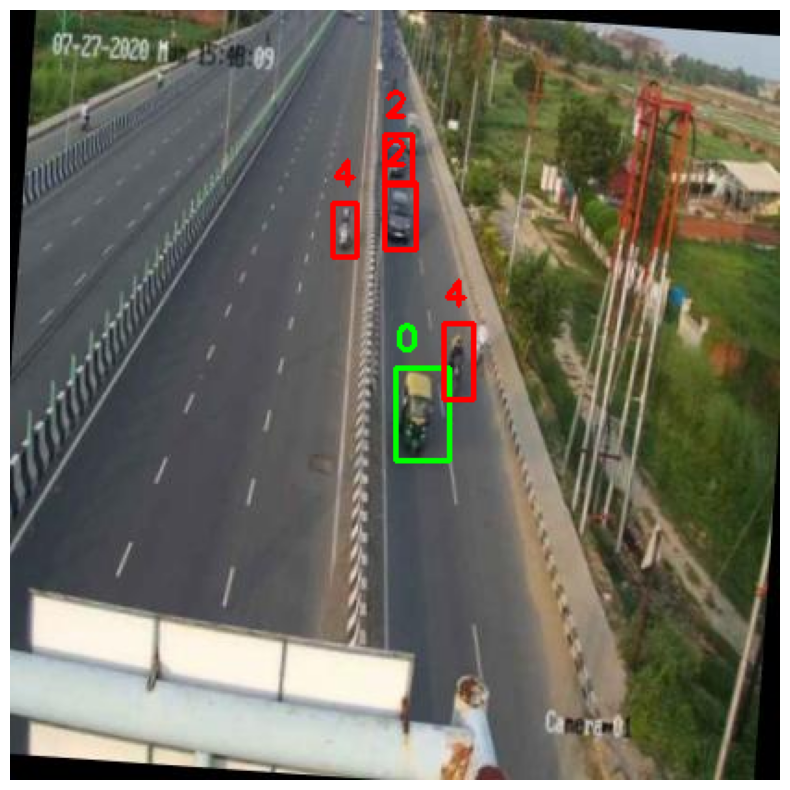

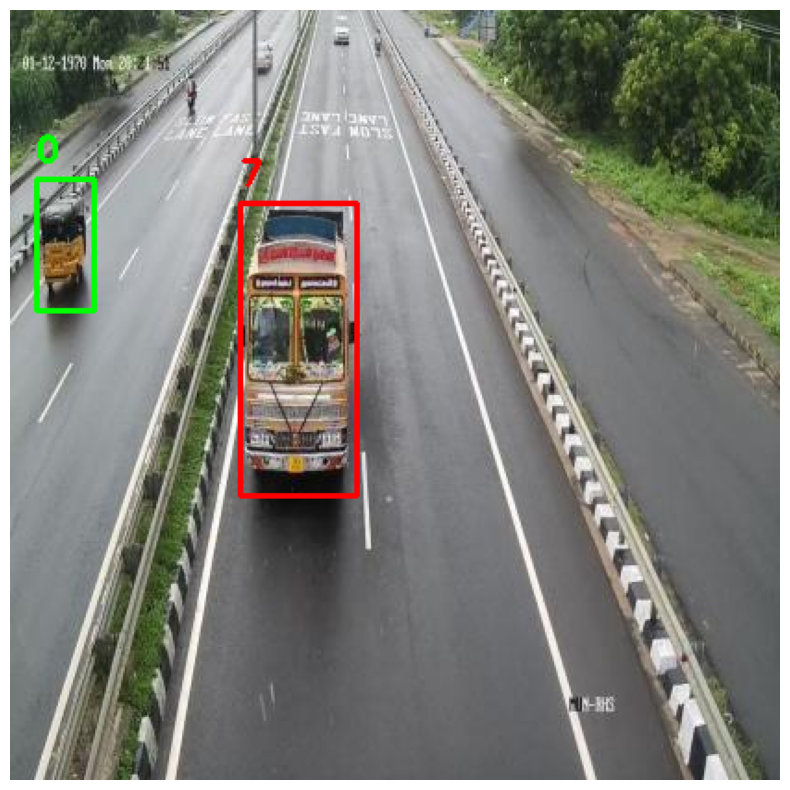

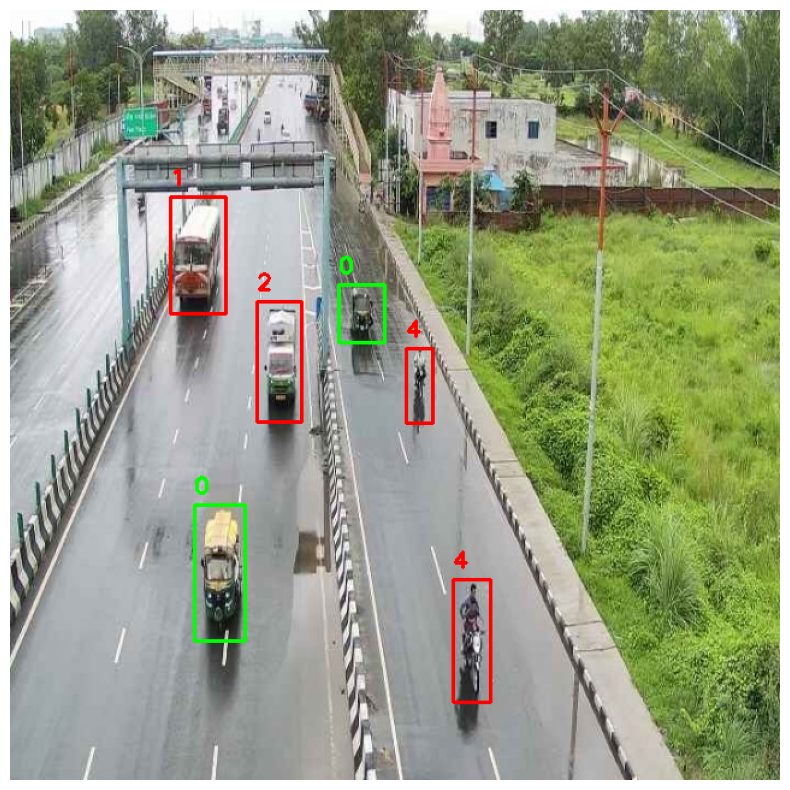

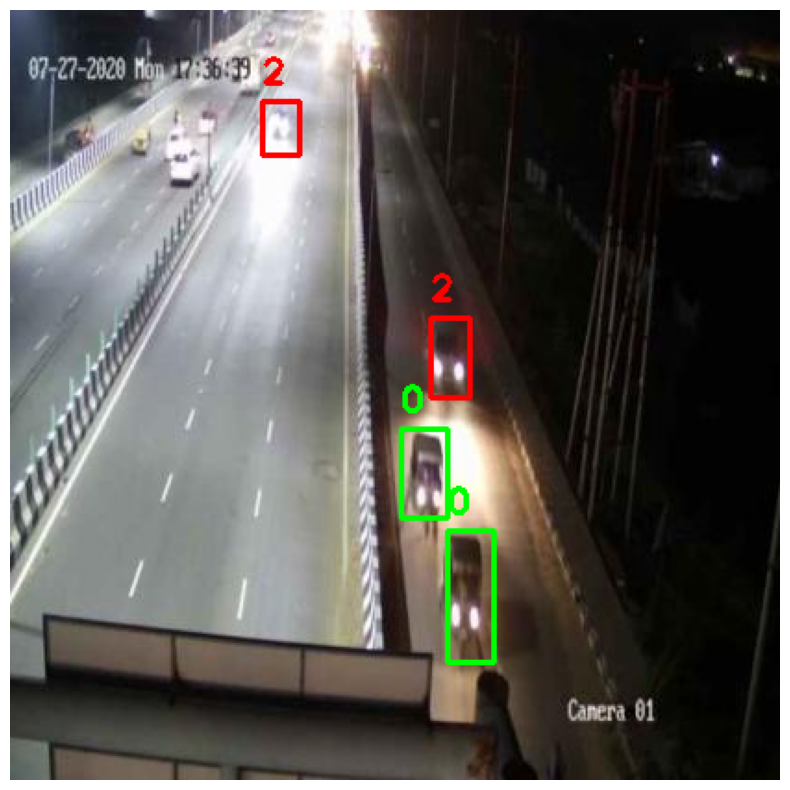

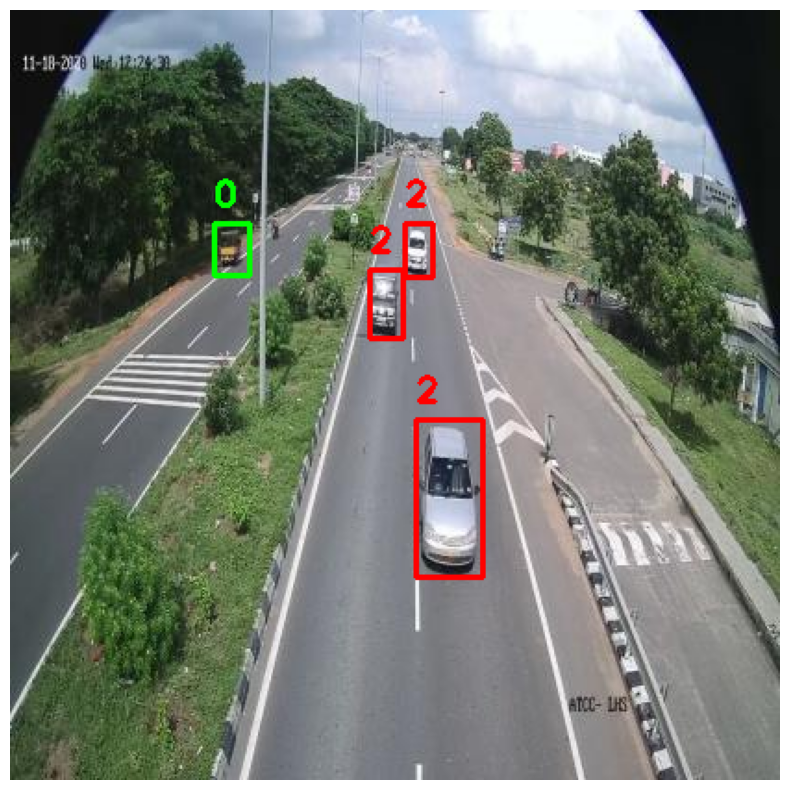

In [ ]:
show_image_with_all_bboxes(df_kaggle, filter_label=0)

Kaggle dataframe Labels:  
0 = Auto  
1 = Bus  
2 = Car  
3 = LCV  
4 = Motorcycle  
5 = Multi-Axle  
6 = Tractor  
7 = Truck

## 2.2 Google Images


## 2.3 Live Camera Feeds


# 3. Data Opschonen en Transformeren

Beschrijf de stappen voor data cleaning, data augmentation en data transformation.

In deze sectie beschrijf je de stappen voor het opschonen en transformeren van de data. Gebruik markdown-cellen om elke stap te beschrijven en code-cellen om de transformaties uit te voeren.

Data Cleaning

Beschrijf hoe je de afbeeldingen opschoont (bijvoorbeeld door ze allemaal naar hetzelfde formaat te converteren).

Voer kleurnormalisatie uit en pas cropping en padding toe waar nodig.

Data Augmentation

Beschrijf hoe je data augmentation toepast om de dataset te vergroten en het model robuuster te maken.

Gebruik technieken zoals rotatie, spiegeling, schalen, translatie, shearing en cropping.

Data Transformation

Beschrijf hoe je de afbeeldingen transformeert om ze geschikt te maken voor machine learning (bijvoorbeeld normalisatie en kleurtransformaties).

## 3.1 Data Cleaning

## 3.2 Data Augmentation

## 3.3 Data Transformation

# 4. Machine Learning Pipeline

Beschrijf hoe het objectdetectiemodel wordt getraind en geëvalueerd.


In deze sectie beschrijf je hoe je het objectdetectiemodel traint en evalueert. Gebruik markdown-cellen om elke stap te beschrijven en code-cellen om het model te trainen en te evalueren.

Objectdetectie Model

Beschrijf hoe je een objectdetectiemodel (bijvoorbeeld YOLO, Faster R-CNN of EfficientDet) traint op de dataset.

Leg uit hoe je het model evalueert met behulp van metrieken zoals precisie, recall en F1-score.

Image Captioning

Beschrijf eventueel hoe je een image captioning-model toevoegt om beschrijvingen van gedetecteerde voertuigen te genereren.



## 4.1 Train-Test Split

In [ ]:
destination_root = '/content/drive/MyDrive/Colab Notebooks/data/working/dataset'

os.makedirs(os.path.join(destination_root, 'train/images'), exist_ok=True)
os.makedirs(os.path.join(destination_root, 'train/labels'), exist_ok=True)
os.makedirs(os.path.join(destination_root, 'test/images'), exist_ok=True)
os.makedirs(os.path.join(destination_root, 'test/labels'), exist_ok=True)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

for img, lbl in zip(train_images, train_labels):
    shutil.copy(os.path.join(images_path, img), os.path.join(destination_root, 'train/images', img))
    shutil.copy(os.path.join(labels_path, lbl), os.path.join(destination_root, 'train/labels', lbl))

for img, lbl in zip(test_images, test_labels):
    shutil.copy(os.path.join(images_path, img), os.path.join(destination_root, 'test/images', img))
    shutil.copy(os.path.join(labels_path, lbl), os.path.join(destination_root, 'test/labels', lbl))

## 4.2 Model Bouwen

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/data/working/dataset'

# Create the directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

In [ ]:
data_yaml = {
    'train': '/content/drive/MyDrive/Colab Notebooks/data/working/dataset/train',
    'val': '/content/drive/MyDrive/Colab Notebooks/data/working/dataset/test',
    'names': ['auto', 'bus', 'car', 'lcv', 'motorcycle', 'multiaxle', 'tractor', 'truck']
}

with open('/content/drive/MyDrive/Colab Notebooks/data/working/dataset/data.yaml', 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

## 4.3 Model Trainen

In [ ]:
# Laad een YOLOv8n model
model = YOLO('yolov8n.pt')  # Kies hier eventueel een ander model

# Definieer het pad naar je data.yaml bestand
data_yaml_path = '/content/drive/MyDrive/Colab Notebooks/data/working/dataset/data.yaml'

# Train het model
results = model.train(data=data_yaml_path, epochs=10)  # Pas het aantal epochs aan indien nodig

Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/data/working/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspect

train: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/train/labels... 6574 images, 14 backgrounds, 0 corrupt: 100%|██████████| 6574/6574 [00:50<00:00, 129.90it/s]

train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/train/images/highway_3297_2020-08-26.jpg: 1 duplicate labels removed


train: New cache created: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 3.7±2.8 ms, read: 8.7±8.9 MB/s, size: 65.3 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/test/labels... 1644 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1644/1644 [00:24<00:00, 67.21it/s] 

val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/test/images/highway_2784_2020-08-26.jpg: 1 duplicate labels removed


val: New cache created: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/test/labels.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/21 17:55:13 INFO mlflow.tracking.fluent: Experiment with name '/Shared/Ultralytics' does not exist. Creating a new experiment.
2025/05/21 17:55:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/05/21 17:55:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/21 17:55:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/05/21 17:55:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/05/21 17:55:18 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/05/21 17:55:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(7bd7498c895d4f0bbd370cf55b0c6d36) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.14G      1.521       2.21      1.163         35        640: 100%|██████████| 411/411 [02:13<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:19<00:00,  2.66it/s]


                   all       1644       5231      0.418       0.59      0.497      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.65G      1.411      1.425      1.111         38        640: 100%|██████████| 411/411 [02:03<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.78it/s]


                   all       1644       5231      0.535      0.609      0.551      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.66G      1.384      1.211      1.101         42        640: 100%|██████████| 411/411 [02:01<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.82it/s]


                   all       1644       5231      0.613       0.61      0.616      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.67G      1.356      1.088      1.097         46        640: 100%|██████████| 411/411 [02:02<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


                   all       1644       5231      0.521      0.666      0.611      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.69G      1.323      1.017      1.083         48        640: 100%|██████████| 411/411 [02:03<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.91it/s]

                   all       1644       5231      0.635      0.715      0.698       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.71G      1.286      0.953       1.07         41        640: 100%|██████████| 411/411 [02:03<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  3.00it/s]


                   all       1644       5231      0.643      0.727      0.713       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.72G      1.268     0.9202      1.062         42        640: 100%|██████████| 411/411 [02:02<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]

                   all       1644       5231      0.707      0.696      0.743      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.74G      1.243     0.8804      1.054         44        640: 100%|██████████| 411/411 [02:03<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  3.02it/s]


                   all       1644       5231      0.682      0.745      0.761      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.76G      1.216     0.8379      1.044         45        640: 100%|██████████| 411/411 [02:03<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:16<00:00,  3.06it/s]


                   all       1644       5231      0.719      0.735      0.771      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.78G      1.193      0.806      1.035         33        640: 100%|██████████| 411/411 [02:03<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  3.00it/s]

                   all       1644       5231      0.733      0.747      0.794      0.551



10 epochs completed in 0.396 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:21<00:00,  2.44it/s]


                   all       1644       5231      0.733      0.748      0.794      0.552
                  auto        144        155      0.636      0.826      0.806      0.492
                   bus        239        255      0.783      0.793      0.841      0.627
                   car       1153       2285      0.868      0.912      0.943      0.647
                   lcv        182        186      0.646      0.431      0.595      0.449
            motorcycle        842       1498      0.773      0.789      0.847      0.461
             multiaxle        230        241      0.683      0.656      0.724      0.583
               tractor         31         31      0.902      0.774      0.857      0.616
                 truck        519        580      0.573        0.8      0.743      0.539
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train3
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=

## 4.4 Model Evalueren


0: 640x640 2 cars, 2 motorcycles, 31.1ms
1: 640x640 4 cars, 31.1ms
Speed: 7.7ms preprocess, 31.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
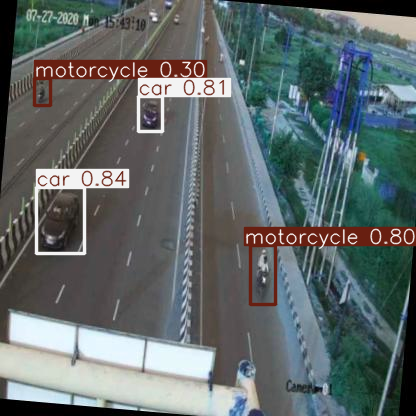

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
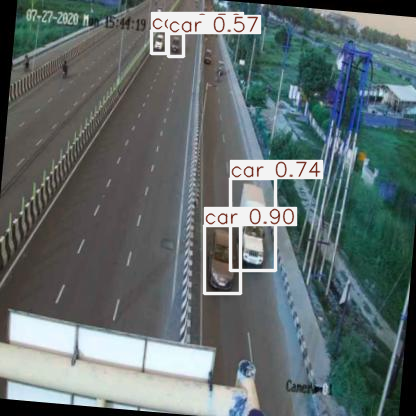

In [ ]:
# Laad het getrainde model (of gebruik het modelobject van de training)
model = YOLO('/content/runs/detect/train3/weights/best.pt') # Pas dit pad aan naar waar je model is opgeslagen

# Definieer de paden naar de afbeeldingen die je wilt gebruiken voor predictie
# Je kunt hier een lijst van afbeeldingspaden opgeven, bijvoorbeeld uit je testset
predict_images = [
    '/content/drive/MyDrive/Colab Notebooks/data/working/dataset/test/images/Highway_1000_2020-07-30_jpg.rf.e9364fb1c7d1bf9f8cbea3d1c1575050.jpg',
    '/content/drive/MyDrive/Colab Notebooks/data/working/dataset/test/images/Highway_1006_2020-07-30_jpg.rf.c58b7b2098d969e925b271bcd436ac25.jpg',
    # Voeg hier meer afbeeldingspaden toe
] # Pas deze paden aan

# Voer predicties uit
results = model.predict(predict_images)

# Toon de resultaten
for result in results:
    display(result.plot()) # result.plot() tekent de bounding boxes op de afbeelding

# 5. Deployment

Beschrijf hoe het model wordt gedeployed op edge-apparaten en in de cloud.

In deze sectie beschrijf je hoe je het model deployt op edge-apparaten en in de cloud. Gebruik markdown-cellen om de deploymentstrategie te beschrijven.

Edge Deployment

Beschrijf hoe je het model implementeert op edge-apparaten zoals slimme camera's of embedded systemen.

Leg uit hoe je ervoor zorgt dat het model realtime voertuigdetectie kan uitvoeren.

Cloud Deployment

Beschrijf hoe je het geavanceerde deep learning-model in de cloud deployt voor voertuigclassificatie.



## 5.1 Edge Deployment

## 5.2 Cloud Deployment

# 6. Monitoring en Feedback

Beschrijf hoe de prestaties van het model worden gemonitord en hoe het model wordt hertraind op basis van nieuwe data.

In deze sectie beschrijf je hoe je de prestaties van het model monitort en hoe je het model hertraind op basis van nieuwe data. Gebruik markdown-cellen om de monitoringstrategie te beschrijven.

Data Drift Detection

Beschrijf hoe je veranderingen in de inkomende data detecteert en hoe je hierop reageert.

Model Performance Monitoring

Beschrijf hoe je de nauwkeurigheid, recall en precision van het model continu monitort.

Leg uit hoe je automatisch logging van verkeerde voorspellingen implementeert.

Hertraining

Beschrijf hoe je het model periodiek hertraind op basis van nieuwe data en feedback.

7. Conclusie


## 6.1 Data Drift Detection

## 6.2 Hertraining

# 7. Conclusie

Geef een samenvatting van de datapijplijn en bespreek eventuele uitdagingen of verbeterpunten.

In deze sectie geef je een samenvatting van de datapijplijn en bespreek je eventuele uitdagingen of verbeterpunten. Gebruik markdown-cellen om de conclusie te schrijven.




# 8. Bronvermelding